# Topic Deep Dive: Optimal Ratio Split for Multiple Variants in an A/B Test

It seems relatively well-known that when there are 2 groups, a Control and a Treatment, then it is optimal to keep them at equal sizes (i.e., a 50/50 split), but when there are multiple treatments, it's unclear as to what the best split is. Below, we'll discuss these topics and simulate the data as demonstration.

The below discussion is taken mostly from ([Kohavi et al., 2022](https://drive.google.com/file/d/1oK2HpKKXeQLX6gQeQpfEaCGZtNr2kR76/view?usp=sharing)).

## *In theory*, a single control can be shared with several treatments, and the theory says that a larger control will be beneficial to reduce the variance

Consider the test statistic of a two-sample $t$-test:

$$t=\frac{(\overline{x}_1 - \overline{x}_2) - d_0}{s_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$$

Note how as $N=\left(\frac{1}{n_1} + \frac{1}{n_2}\right)$ gets smaller, the test statistic rises, meaning that it will lower your $p$-value, which means that you would be rejecting your null more often than if $N$ was bigger.

Assuming $n_1+n_2=100$, let's graphically see what happens to $N$ when $n_1$ and $n_2$ change

In [1]:
def harmonic_mean(n1,n2):
  """
  computes the harmonic mean
  """
  return ((1/n1) + (1/n2))

In [2]:
f = 100

x = [i / f for i in list(range(1,f))]
y = []

for k in range(1,f):
  y.append(harmonic_mean(k,f-k))

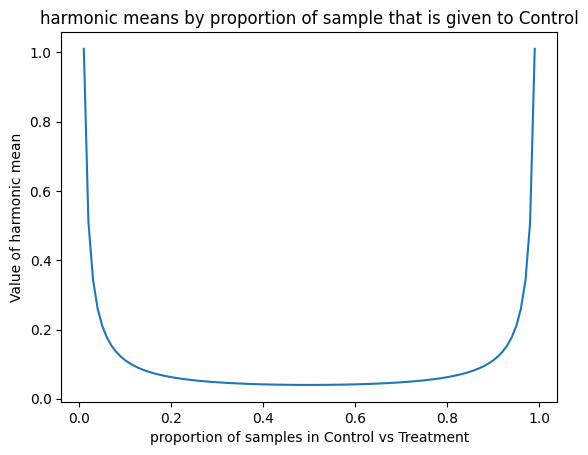

In [3]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.title('harmonic means by proportion of sample that is given to Control')
plt.xlabel('proportion of samples in Control vs Treatment')
plt.ylabel('Value of harmonic mean')
plt.show()

We see how the harmonic mean is minimized at proportion 0.5, meaning that in a two-sample scenario, we would like a 50/50 split with Control and Treatment.

In the presense of multiple treatments, in theory, it is said that a single control can be shared with several treatments,
and the theory says that a larger control will be beneficial to
reduce the variance.

When there is one control taking a proportion $x$ of users and $k$ equally sized treatments with size $\frac{1-x}{k}$, the optimal control size should be chosen by minimizing the sum
$$\frac{k}{1-x}+\frac{1}{x}$$

To minimize this, we differentiate this sum and get

$$\frac{k}{(1-x)^2}-\frac{1}{x^2}$$

Therefore, the optimal solution is

$$(k-1)x^2+2x-1=0$$

which amounts to

$$\frac{1}{\sqrt{k}+1}$$

This means that when $k=3$, as in we want 3 different treatments, instead of using 25% for all buckets, we use $1/(\sqrt{3}+1)\approx 36.6\%$ for the control, meaning that each of the 3 treatments get $21.1\%$ each, meaning that Control is 1.5x larger than treatment.

## However, in practice, when distributions are skewed, in an unequal assignment, the $t$-test cannot maintain the nominal Type-I error rate on both tails

Kohavi et al. 2022 explain that
> *When a metric is positively skewed, and the control is larger than the treatment, the t-test will over-estimate the Type-I error on one tail and under-estimate on the other tail because the skewed distribution
convergence to normal is different. But when equal sample sizes
are used, the convergence is similar and the $\Delta$ (observed delta) is
represented well by a Normal- or $t$-distribution*

To explore this topic, we need to explain a little deeper on what the Type-I error is and its implications. Remember that the Type-I error is the false positive rate, which can be thought of as rejecting the null even though in truth the null was correct.

To make this more intuitive, let's create a function below that performs a $t$-test.

Note that while there are different variations of an unpaired $t$-test such as the standard Student's $t$-test or Welch's $t$-test, where the difference is a difference in assumptions of equal vs unequal variances, it is actually recommended that Welch's $t$-test should be applied regardless, as it performs close to the Student's $t$-test even when variances are in fact equal. The alternative would be to test if variances are equal and then choose appropriately, but that is no longer recommended, noted from various studies such as in 2004 and 2006.

In addition, it is reported that Welch's $t$-test remains robust for skewed distributions and large sample sizes (this part confuses me though - why would it not be robust for large sample sizes? Perhaps it means relative to Student's $t$-test)

Since Kohavi's text does not state which variation of the $t$-test it is using, we will simply use both

In [4]:
import numpy as np

def datasim(samples=10000):
  """
  simulates data from a "skewed" binomial sample (p=0.001)

  Returns:
  - numpy array
  """
  return np.random.binomial(n=1,p=0.001,size=samples)

Below we see the central limit theorem at play. Quick note though - this is essentially a test of "proportions", and $t$-tests aren't actually recommended for it, instead, a $z$-test is. I believe this is because (assuming other assumptions are not relevant, such as sample size constraints) the $z$-test assumes that variance is known - and in this case, it is, because for a binomial, the variance is a function of the mean and we know the mean. However, as we are tryig to somewhat replicate the example from Kohavi et al. 2022, we will proceed with the $t$-test.

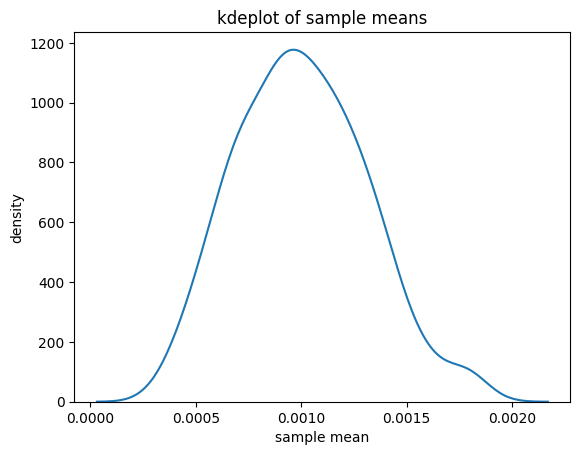

In [5]:
import seaborn as sns
samples = [np.mean(datasim(samples=10000)) for _ in range(500)]
sns.kdeplot(samples)
plt.title('kdeplot of sample means');plt.xlabel('sample mean');plt.ylabel('density')
plt.show()

Here we just perform a $t$-test just once just to see what to expect. It's an A/A test, meaning that there isn't actually a difference in the overall population we are sampling from. This means that we should usually expect the $p$-value to be moderate.

In [6]:
from scipy.stats import ttest_ind

samples1 = datasim(samples=10000)
samples2 = datasim(samples=10000)

p_value = ttest_ind(samples1, samples2, equal_var=False)[1]

print("mean 1: ",np.mean(samples1), "mean 2: ",np.mean(samples2),"p-value:", p_value)

mean 1:  0.0005 mean 2:  0.0006 p-value: 0.762975494054398


By using $\alpha=0.05$, we are saying that the significance level is 0.05, which means that there is a 5% chance of committing a Type I error. In other words, about 5% of the time, these A/A tests will lead to the rejection of the null hypothesis when it is actually true. Let's see if this is true

In [7]:
def evaluate(num_iterations=10000,alpha=0.05):
  """
  perform a number of specified tests and report % of false positives
  """
  rejections = []
  for i in range(num_iterations):
    temp = ttest_ind(datasim(), datasim(), equal_var=False)[1]
    if temp <= alpha:
      rejections.append(1)
    else:
      rejections.append(0)
  return np.sum(rejections) / num_iterations

In [8]:
evaluate()

0.0515

We see that this is true. However, in Kohavi et al. 2022, they evaluate both a right tail and a left tail, so we actually want to evaluate the various versions of the one-sided $t$-tests. Furthermore, they saw that while for equal sizes between control and treatment the convergence was strong, it was not for unequal sample sizes.

In [9]:
def evaluate(num_iterations=10000,alpha=0.05,side='less',not_welch=False,sample_imbalance=1):
  """
  perform a number of specified tests and report % of false positives
  """
  treat_size = 10000
  control_size = treat_size * sample_imbalance
  rejections = []
  for i in range(num_iterations):
    temp = ttest_ind(datasim(control_size), datasim(treat_size), equal_var=not_welch,alternative=side)[1]
    if temp <= alpha:
      rejections.append(1)
    else:
      rejections.append(0)
  return np.sum(rejections) / num_iterations

In [10]:
# right tail test, equal sample sizes
evaluate(side='greater',not_welch=False,sample_imbalance=1)

0.0485

In [11]:
# right tail test, unequal sample size (control is 9x bigger)
evaluate(side='greater',not_welch=False,sample_imbalance=9)

0.0912

In [12]:
# left tail test, equal sample sizes
evaluate(side='less',not_welch=False,sample_imbalance=1)

0.0479

In [13]:
# left tail test, unequal sample sizes (control is 9x bigger)
evaluate(side='less',not_welch=False,sample_imbalance=9)

0.0245

In [14]:
# two-sided test, unequal sample sizes (control is 9x bigger)
evaluate(side='two-sided',not_welch=False,sample_imbalance=9)

0.0668

Let's take note of these results:
- When sample sizes were equal, for all sided tests (left, right, two-sided) all returned about the same type 1 error rate of 0.05.
- For the test where the alternative is "greater" and control was 9x larger, significantly more tests were rejected than they should have.
- For the test wehre the alternative is "less" and control was 9x larger, significantly less tests were rejected than they should have

In Kohavi et al. 2022, they mention how when sample sizes are equal, the skew of the delta is close to 0. In addition, "It is closer to the skewness of
treatment metric when control is much larger".

Furthermore, they state that the skewness of a metric (in this case I believe the delta) decreases with the rate of $\sqrt{n}$ as the sample size increases. They recommend that sample sizes for each variant be large enough such that the skewness of metrics be no greater than $1/\sqrt{355}=0.053$

This reflects the entry in the Wikipedia page for skewness that also recommend that skewness should be below $0.05$. To get a perspective of how large our skew is (due to the binomial probability $p$ being so small), we can compute it easily below:

In [16]:
from scipy.stats import skew
skew(np.random.binomial(n=1,p=0.001,size=100000))

31.575322658699797

## In Summary

Kohavi et al. 2022 recommend against the usage of a large control because the convergence of normality (of the sample means) differ between control and treatment if control has a much higher sample size, which can lead to overestimations or underestimations of Type-I error. Therefore, when performing a test with multiple treatments, an equal ratio split should suffice.